In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


chirps_data = xr.open_dataset('chirps-v2_monthly_africa_2.5.nc')
chirps_data = chirps_data.sel(longitude=slice(30, 52), latitude=slice(-10, 12))


/home/chris/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mam_precip = chirps_data.precip.sel(time=chirps_data['time.month'].isin([3, 4, 5])).groupby('time.year').mean('time')

base_period = mam_precip.sel(year=slice(1979, 2010))
base_mean = base_period.mean('year')

mam_anomalies = mam_precip - base_mean

In [3]:
oni_data = pd.read_csv('ONI.csv')
oni_data = oni_data.set_index('Year')
lag_oni = oni_data.shift(1).drop(index=1981)

lag_common_years = np.intersect1d(mam_anomalies.year,lag_oni.index)
mam_anomalies_lag = mam_anomalies.sel(year=lag_common_years)
oni_data_lag = oni_data.loc[lag_common_years]

In [4]:
lag_common_years

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [5]:
def calculate_lagged_correlation(anomalies_lag, oni_data_lag, lag_season='MAM'):
    correlations = np.zeros((anomalies_lag.latitude.size, anomalies_lag.longitude.size))
    p_values = np.zeros_like(correlations)

    for i in range(anomalies_lag.latitude.size):
        for j in range(anomalies_lag.longitude.size):
            precip_series = anomalies_lag[:, i, j].values
            year_indices = anomalies_lag.year.values
            oni_series = oni_data_lag.loc[year_indices, lag_season].values
            complete_id = ~np.isnan(precip_series) & ~np.isnan(oni_series)
            if complete_id.sum() > 1:
                corr, p_value = pearsonr(precip_series[complete_id], oni_series[complete_id])
                correlations[i, j] = corr
                p_values[i, j] = p_value

    return correlations, p_values

Lagg_correlation, p_values = calculate_lagged_correlation(mam_anomalies_lag, lag_oni)

pd.DataFrame(Lagg_correlation)



,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,0.050071,0.065954,0.029412,0.066569,0.087341,0.105656,0.117953,0.126672,0.194548,0.249278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.013616,0.043640,0.076154,0.088790,0.067910,0.010952,-0.004379,0.083930,0.133257,0.275767,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.005854,0.083353,0.087577,-0.001072,-0.061163,-0.077002,-0.005158,0.129803,0.231795,0.316462,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,-0.005752,0.043095,0.046649,-0.021733,0.006957,0.071082,0.098836,0.160835,0.197275,0.287647,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,-0.038667,-0.029038,-0.053123,-0.065090,0.031938,0.105384,0.157938,0.168635,0.179164,0.230552,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.186751,0.212853,0.216042,0.276432,0.254181,0.244865,0.295849,0.325372,0.325639,0.282310,...,0.111970,0.036387,0.013661,-0.007353,0.075228,0.231373,0.115638,0.000000,0.0,0.0
84,0.223572,0.216321,0.205310,0.233404,0.260842,0.302577,0.316894,0.323975,0.347970,0.364055,...,0.017366,-0.054194,-0.046094,-0.050180,0.072084,0.171713,-0.093614,0.000000,0.0,0.0
85,0.243346,0.209859,0.202030,0.216688,0.256586,0.343632,0.374187,0.330060,0.331046,0.345803,...,0.017568,-0.065577,-0.077277,-0.047613,-0.005561,0.056507,-0.101434,0.000000,0.0,0.0
86,0.264577,0.221421,0.222025,0.254548,0.265175,0.338422,0.385239,0.360504,0.339518,0.301458,...,0.000000,0.000000,-0.061356,-0.045277,-0.013255,0.038338,-0.027108,0.015221,0.0,0.0


In [17]:
oni_data['Mean'] = np.nan
oni_data['Mean'] = oni_data.mean(axis=1)
oni_data


,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ,Mean
Year,,,,,,,,,,,,,
1981,-0.3,-0.5,-0.5,-0.4,-0.3,-0.3,-0.3,-0.2,-0.2,-0.1,-0.2,-0.1,-0.283333
1982,0.0,0.1,0.2,0.5,0.7,0.7,0.8,1.1,1.6,2.0,2.2,2.2,1.008333
1983,2.2,1.9,1.5,1.3,1.1,0.7,0.3,-0.1,-0.5,-0.8,-1.0,-0.9,0.475000
1984,-0.6,-0.4,-0.3,-0.4,-0.5,-0.4,-0.3,-0.2,-0.2,-0.6,-0.9,-1.1,-0.491667
1985,-1.0,-0.8,-0.8,-0.8,-0.8,-0.6,-0.5,-0.5,-0.4,-0.3,-0.3,-0.4,-0.600000
1986,-0.5,-0.5,-0.3,-0.2,-0.1,0.0,0.2,0.4,0.7,0.9,1.1,1.2,0.241667
1987,1.2,1.2,1.1,0.9,1.0,1.2,1.5,1.7,1.6,1.5,1.3,1.1,1.275000
1988,0.8,0.5,0.1,-0.3,-0.9,-1.3,-1.3,-1.1,-1.2,-1.5,-1.8,-1.8,-0.816667
1989,-1.7,-1.4,-1.1,-0.8,-0.6,-0.4,-0.3,-0.3,-0.2,-0.2,-0.2,-0.1,-0.608333


In [16]:
df

Year
1981   -0.283333
1982    1.008333
1983    0.475000
1984   -0.491667
1985   -0.600000
1986    0.241667
1987    1.275000
1988   -0.816667
1989   -0.608333
1990    0.308333
1991    0.641667
1992    0.641667
1993    0.325000
1994    0.475000
1995   -0.158333
1996   -0.466667
1997    1.166667
1998   -0.066667
1999   -1.233333
2000   -0.825000
2001   -0.300000
2002    0.633333
2003    0.258333
2004    0.458333
2005    0.033333
2006    0.058333
2007   -0.608333
2008   -0.775000
2009    0.300000
2010   -0.475000
2011   -0.850000
2012   -0.150000
2013   -0.325000
2014    0.108333
2015    1.458333
2016    0.325000
2017   -0.208333
2018    0.008333
2019    0.475000
2020   -0.366667
2021   -0.725000
2022   -0.941667
2023    0.833333
dtype: float64

In [11]:
common_years = np.intersect1d(mam_precip.year, oni_data.index)
mam_precip = mam_precip.sel(year=common_years)
oni_data = oni_data.loc[common_years]
oni_data

,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ,Mean
Year,,,,,,,,,,,,,
1981,-0.3,-0.5,-0.5,-0.4,-0.3,-0.3,-0.3,-0.2,-0.2,-0.1,-0.2,-0.1,-0.283333
1982,0.0,0.1,0.2,0.5,0.7,0.7,0.8,1.1,1.6,2.0,2.2,2.2,1.008333
1983,2.2,1.9,1.5,1.3,1.1,0.7,0.3,-0.1,-0.5,-0.8,-1.0,-0.9,0.475000
1984,-0.6,-0.4,-0.3,-0.4,-0.5,-0.4,-0.3,-0.2,-0.2,-0.6,-0.9,-1.1,-0.491667
1985,-1.0,-0.8,-0.8,-0.8,-0.8,-0.6,-0.5,-0.5,-0.4,-0.3,-0.3,-0.4,-0.600000
1986,-0.5,-0.5,-0.3,-0.2,-0.1,0.0,0.2,0.4,0.7,0.9,1.1,1.2,0.241667
1987,1.2,1.2,1.1,0.9,1.0,1.2,1.5,1.7,1.6,1.5,1.3,1.1,1.275000
1988,0.8,0.5,0.1,-0.3,-0.9,-1.3,-1.3,-1.1,-1.2,-1.5,-1.8,-1.8,-0.816667
1989,-1.7,-1.4,-1.1,-0.8,-0.6,-0.4,-0.3,-0.3,-0.2,-0.2,-0.2,-0.1,-0.608333


In [18]:
def calculate_correlation(mam_precip, oni_data, column='Mean'):
    correlations = np.zeros((mam_precip.latitude.size, mam_precip.longitude.size))
    p_values = np.zeros_like(correlations)

    for i in range(mam_precip.latitude.size):
        for j in range(mam_precip.longitude.size):
            precip_series = mam_precip[:, i, j].values
            year_indices = mam_precip.year.values
            oni_series = oni_data.loc[year_indices, column].values
            complete_id = ~np.isnan(precip_series) & ~np.isnan(oni_series)
            if complete_id.sum() > 1:
                corr, p_value = pearsonr(precip_series[complete_id], oni_series[complete_id])
                correlations[i, j] = corr
                p_values[i, j] = p_value

    return correlations, p_values

correlations, p_values = calculate_correlation(mam_precip, oni_data)

Text(0, 0.5, 'Latitude')

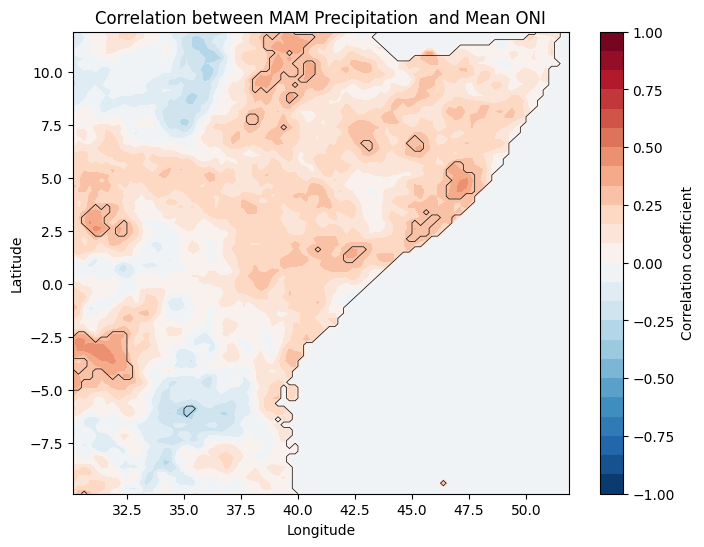

In [19]:
plt.figure(figsize=(8, 6))
plt.contourf(chirps_data.longitude, chirps_data.latitude, correlations, cmap='RdBu_r', levels=np.linspace(-1, 1,25))
plt.colorbar(label='Correlation coefficient')

plt.contour(chirps_data.longitude, chirps_data.latitude, p_values < 0.05, levels=[0.5], colors='black', linewidths=0.5)
plt.title('Correlation between MAM Precipitation  and Mean ONI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')